# Using the Pharaglow-Analysis toolset for data analysis

In [227]:
import pg_analysis
import pg_analysis.plotter as pga
import matplotlib.pylab as plt
from pg_analysis import style
import numpy as np
import importlib
importlib.reload(pg_analysis.plotter)

<module 'pg_analysis.plotter' from '/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py'>

## I/O

### Loading data

In [228]:
# load data from pharaglow results file
control = pga.Experiment(strain='GRU101', condition='Entry', scale=2.34, fps = 30.)
#control.load_data('/home/mscholz/Desktop/TestOutput_MS0006')

# ... or load from a previously pickled Experiment object.
control = pga.Experiment.load('Test')
#control = pga.Experiment.load('LawnEntryPickle_May')

In [230]:
control

Experiment 
 Strain: GRU101,
 Condition: lawn entry
 N = 26.

### Add metadata

In [231]:
# experimental metdadata
info = {"strain":"GRU101", "experimenter":"M.Scholz", "food":"OP50", 'stage':'adults'}
control.define_metadata(info)

In [232]:
control.experiment_metadata

{'strain': 'GRU101',
 'experimenter': 'M.Scholz',
 'food': 'OP50',
 'stage': 'adults'}

### Saving and exporting data

In [233]:
# ... we can also dump a pickle object to save the current state of the Experiment variable.
control.dump('Test_2')

# or export it into the wcon format https://github.com/openworm/tracker-commons/blob/master/WCON_format.md
control.save_wcon(filepath = 'test.wcon', tag = '@INF')

### Filter data

In [234]:
print(f'Sample remaining: {len(control)}')

# we check if conditions are fullfilled for each sample and retain only suitable ones. Here - we filter by duration of the tracks
tmp = []
for worm in control.samples:
    if len(worm.data)>worm.fps*30 and 'inside' in worm.data.columns:
        tmp.append(worm)
control.samples = tmp

print(f'Sample remaining: {len(control)}')

Sample remaining: 26
Sample remaining: 26


### 2. Eploring the Experiment object
An Experiment object is a container for the Worm object. Each worm object contains the phargalow data table. You can print either the Experiment or a single worm to get a description.

In [235]:
#the class supports slicing
# get just a few samples. a is still an Experiment object
a = control[0:2]
print(a)

Experiment 
 Strain: GRU101,
 Condition: lawn entry
 N = 2.


In [236]:
# it also allows addition if you loaded two objects for example.
a = control[0]+control[1]
a

Experiment 
 Strain: GRU101,
 Condition: lawn entry
 N = 2.

In [237]:
# if you want to access the underlying worm class, use get_sample(n) 
w = control.get_sample(0)
w

Worm 
 with underlying data:              index            x            y        frame        pumps  \
count  2109.000000  2109.000000  2109.000000  2109.000000  2109.000000   
mean   1054.000000  2344.065155   861.793526  3445.000000   -55.657279   
std     608.960179   159.620502   434.522380   608.960179    10.107087   
min       0.000000  2044.798306   547.937870  2391.000000   -76.650342   
25%     527.000000  2225.957594   568.809082  2918.000000   -63.302666   
50%    1054.000000  2362.716891   595.624066  3445.000000   -57.640242   
75%    1581.000000  2446.491396  1095.494787  3972.000000   -48.987779   
max    2108.000000  2708.999041  2034.315436  4499.000000   -10.714797   

            inside         time     velocity   pump_clean         rate  \
count  2023.000000  2109.000000  2108.000000  2109.000000  2109.000000   
mean      0.359367   114.833333    94.614786    -0.005809     3.949772   
std       0.479934    20.298673    73.935953     2.091935     0.845314   
min     

### 3. Calculating additional columns

We can calculate a velocity and pumping rates. But we can also get reversals, a windowed pumping count or recalculate the pumping rate with new peak-finding parameters.

In [238]:
# print available functions
control[:1].calculate_property('help')

dict_keys(['reversals', 'count_rate', 'smoothed', 'pumps', 'nose_speed', 'reversals_nose', 'velocity', 'time', 'preprocess_signal', 'locations'])


In [250]:
# calculate reversals
control.calculate_property('reversals', animal_size=100, angle_threshold=120)
# semi-periodic pumping detection using pyampd
ppars = {'sensitivity' : 0.999, 'min_distance' : 4, 'adaptive_window':120}
control.calculate_property('preprocess_signal', key='pumps', w_outlier=None, w_bg=30, w_smooth=2)
control.calculate_property("pumps", key='pumps_clean', **ppars)

/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:461: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:461: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:461: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:461: RuntimeWarning: invalid value encountered in double_scalars
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:461: Runti

### 4. Aligning data temporally

In [251]:
# to align all worms in an experiment to a global timepoint
#control.align_data(timepoints = [100], tau_before = 300, tau_after = 300, key = None)

# # or align each worm to its own timepoint - here we use the time of lawn entry
tmp = []
for worm in control.samples:
    inside = worm.get_data('inside')
    # make sure it is not always outside the lawn or inside the lawn
    if 0 < np.mean(inside)< 1:
        # get timepoint using the 'insideHead' variable
        tp = worm.get_data('frame').iloc[np.where(worm.get_data('inside')==1)[0][0]]
        worm.multi_align([tp], tau_before=300, tau_after=600, key = None)
        tmp.append(worm)
# make a smaller dataset with just entering worms by using only the entering worms as samples
control.samples = tmp

/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:262: UserWarning: You requested frame. The index of this series will be meaningless.
  warnings.warn(f'You requested {key}. The index of this series will be meaningless.')
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:262: UserWarning: You requested frame. The index of this series will be meaningless.
  warnings.warn(f'You requested {key}. The index of this series will be meaningless.')
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:262: UserWarning: You requested frame. The index of this series will be meaningless.
  warnings.warn(f'You requested {key}. The index of this series will be meaningless.')
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:262: UserWarning: You requested frame. The index of this series will be meaningless.
  warnings.warn(f'You requested {key}. The index of this series will be meaningless.')


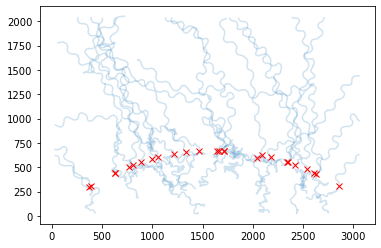

In [252]:
control.plot(plt.gca(), ('x', 'y'), metric = None, plot_type = 'line', color = 'C0', alpha = 0.2)
[plt.plot(w.get_aligned_metric('x', 'mean').loc[0], w.get_aligned_metric('y', 'mean').loc[0], 'rx') for w in control.samples];

### 5. Getting data out

mean 94.61478580153148
sem 1.6103503577616658
std 73.93595338641755
N 2108


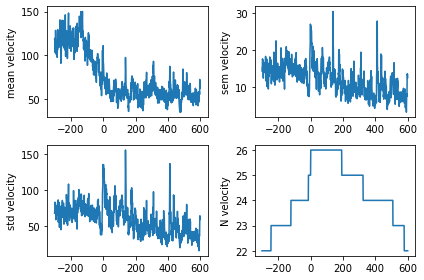

In [253]:
######################################
#
#    calculate metrics at the worm level or experiment level
#
#######################################
# # metric at the worm level, eg. average velocity
w = control.get_sample(0)
for m in ['mean', 'sem', 'std', 'N']:
    t = w.get_metric('velocity', m)
    print(m, t)


# # metric at the experiment level.
plt.figure()
key = 'velocity'
for i, metric in enumerate(['mean', 'sem', 'std', 'N']):
    plt.subplot(2,2,i+1)
    t = control.get_aligned_sample_metric(key, metric, 'mean')
    plt.plot(t, color = 'C0', alpha = 0.1)
    plt.ylabel(f"{metric} {key}")
    
key = 'velocity'
for i, metric in enumerate(['mean', 'sem', 'std', 'N']):
    plt.subplot(2,2,i+1)
    t = control.get_aligned_sample_metric(key, metric, 'mean')
    plt.plot(t, color = 'C0', alpha = 1)
    plt.ylabel(f"{metric} {key}")
plt.tight_layout()

### 5. Plotting utilities

There are built-in plots for quick visulaizations in the package. These are basic and meant to provide quick overviews. 
There are 6 basic plot types illustrated below. 

- 'metric': defines the reducing function across samples (worms)
- 'metric_sample': defines the reducing function across time
- 'plot_type': specify the type of visual 
- 'metric_error': define how an error bar is calculated. Only used for certain plot types.


- all plots take additional matplotlib keyword arguments
- to use a previously aligned dataset, use aligned = True

/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:952: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/style.py:274: UserWarning: The following kwargs were not used by contour: 'color'
  cfset = ax.contourf(xx, yy, f, **kwargs)


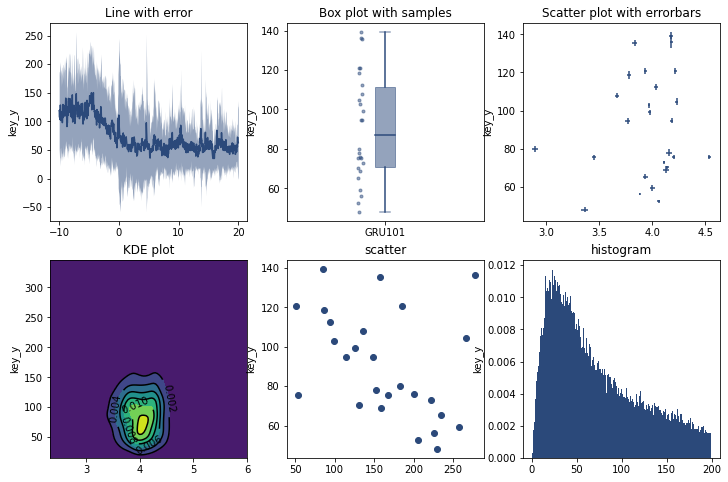

In [254]:
# basic plot types
fig, ((ax1, ax2, ax3), ( ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize = (12, 8))
key_x = 'time'
key_y = 'velocity'

plot, x, y = control.plot(ax1, (key_x, key_y), metric = None, metric_sample = 'mean', plot_type = 'line', metric_error = 'std', aligned = True)
plot, x, y = control.plot(ax2, (key_x, key_y),metric = 'mean', metric_sample = None, plot_type = 'box', loc = 0,)
plot, x, y = control.plot(ax3, ('rate', key_y), metric = 'mean', metric_sample = None, plot_type = 'xy_error_scatter', metric_error = 'sem', marker=None)
plot, x, y = control.plot(ax4, ('rate', key_y), metric = None, metric_sample = 'mean', plot_type = 'density', metric_error = None)
plot, x, y = control.plot(ax5, (key_x, key_y), metric = 'mean', metric_sample = None, plot_type = 'scatter', axis =0)
plot, x, y = control.plot(ax6, key_y, metric = 'collapse', metric_sample = None, plot_type = 'histogram', nbins =range(0,200))

for ax, txt in zip(fig.axes, ['Line with error', 'Box plot with samples', 'Scatter plot with errorbars', 'KDE plot', 'scatter', 'histogram']):
    ax.set_title(txt)
    ax.set_ylabel('key_y')

#### Box plots - summary stats

Very useful to compare datasets. All plot utilities return the underlying dataframes (e.g., here x1, y1), which can be used to calculate statistics.

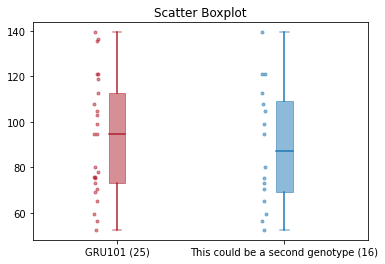

In [255]:
# box plots!
plt.figure()
ax = plt.subplot(111)
ax.set_title('Scatter Boxplot')
# you can filter results by row = here it would be applied before averaging such that individual worms are removed.
control.set_color(style.R1)
plot1, x1, y1 = control.plot(ax, 'velocity',metric = 'mean',  plot_type = 'box', loc = 0, filterfunction = lambda x: np.any(x>300))
N1 = len(y)
# slicing makes a copy! Note how the object doesn't have the same color
plot2, x2, y2 = control[10:100].plot(ax, 'velocity',metric = 'mean', plot_type = 'box', loc = 1, filterfunction = lambda x: np.any(x>0))
# need to add our labels back when doing two plots
ax.set_xticks([0,1])
ax.set_xticklabels([f'GRU101 ({len(y1)})', f'This could be a second genotype ({len(y2)})'])
plt.show()

#### 2D - density and lineplots

/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/plotter.py:952: UserWarning: This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.
  warnings.warn('This option keeps the dataframe index while applying the sample metric which is rarely meaningful. You probably want to align all datasets to their t=0 and rerun with the aligned option.')
/gpfs/soma_fs/home/scholz/usr/miniconda3/envs/pumping/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/soma_interim/home/scholz/Code/Pharaglow-Analysis/pg_analysis/style.py:274: UserWarning: The following kwargs were not used by contour: 'color'
  cfset = ax.contourf(xx, yy, f, **kwargs)


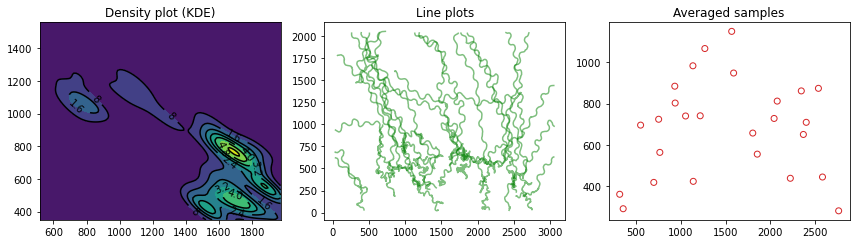

In [256]:
plt.figure(figsize = (12,3.5))
ax = plt.subplot(131)
ax.set_title('Density plot (KDE)')
plot, x, y = control.plot(ax, ('x', 'y'), metric = None, metric_sample = 'mean', plot_type = 'density', metric_error = None)
ax = plt.subplot(132)
ax.set_title('Line plots')
control.plot(ax, ('x', 'y'), metric = None,  alpha = 0.5, color = 'green')
ax = plt.subplot(133)
ax.set_title('Averaged samples')
control.plot(ax, ('x', 'y'), metric = 'mean', plot_type = 'scatter', marker = 'o',facecolor='none',edgecolor='C3')
plt.tight_layout()

#### Scatter in multiple plots

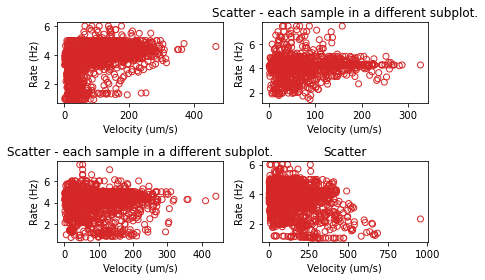

In [257]:
# scatter two variables against each other with different subplot options
plt.figure()
ax0 = plt.subplot(221)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)
axes = [ax0, ax1, ax2, ax3]
for ax in axes:
    ax.set_ylabel('Rate (Hz)')
    ax.set_xlabel('Velocity (um/s)')
ax.set_title('Scatter')
control[:4].plot(axes, ('velocity', 'rate'), metric = None, metric_sample = None, plot_type='scatter', fc ='none', ec = 'C3')
ax1.set_title('Scatter - each sample in a different subplot.')
ax2.set_title('Scatter - each sample in a different subplot.')

plt.tight_layout()

#### Timeseries

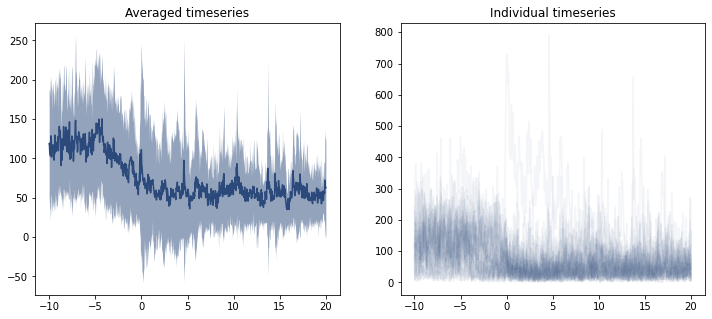

In [258]:
plt.figure(figsize = (12, 5))
control.set_color(style.B1)
ax1 = plt.subplot(121)
ax1.set_title('Averaged timeseries')
control.plot(ax1, 'velocity',  metric = None, metric_sample = 'mean', metric_error = 'std', aligned = True);
ax2 = plt.subplot(122)
ax2.set_title('Individual timeseries')
control.plot(ax2, 'velocity', metric = None, alpha = 0.05, aligned = True);

#### Event plots

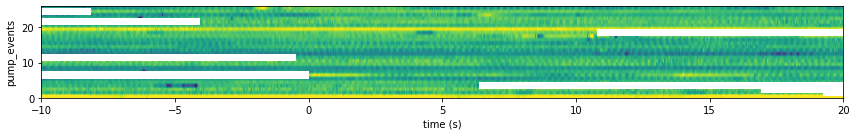

In [259]:
fig, axes = plt.subplots(1,1, figsize=(12,2))

plot, x, y = control.plot(axes, ('time_align','pumps'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=-100, vmax = -30, aligned = True, cmap = 'viridis')#,filterfunction = lambda x:~np.any(np.isnan(x)))
# correct x-axis - use aligned time
plot[0].set_extent([x.mean(axis=1).min(),x.mean(axis=1).max(),0,len(control)])
#axes.set_aspect(len(x)//len(y))
plt.setp(axes, ylabel='pump_events', xlabel = 'time (s)')
plt.tight_layout()

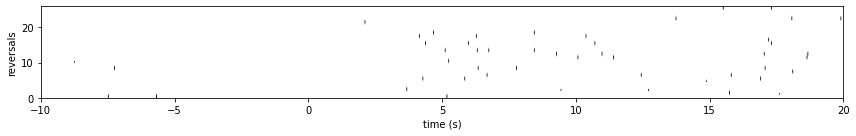

In [261]:
fig, axes = plt.subplots(1,1, figsize=(12,2))

plot, x, y = control.plot(axes, ('time_align','reversals'), metric = None, plot_type = 'raster', 
                                  aspect ='auto', vmin=0, vmax = 1, aligned = True, cmap = 'gray_r')#,filterfunction = lambda x:~np.any(np.isnan(x)))
# correct x-axis - use aligned time
plot[0].set_extent([x.mean(axis=1).min(),x.mean(axis=1).max(),0,len(control)])
#axes.set_aspect(len(x)//len(y))
plt.setp(axes, ylabel='reversals', xlabel = 'time (s)')
plt.tight_layout()